# Variational Coin Toss

Code to go along with [this blog post](http://www.openias.org/variational-coin-toss).

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sco
import scipy.stats as scs # distributions
import scipy.special as scf # beta, digamma functions
import tensorflow as tf

from IPython.display import HTML
from matplotlib import animation

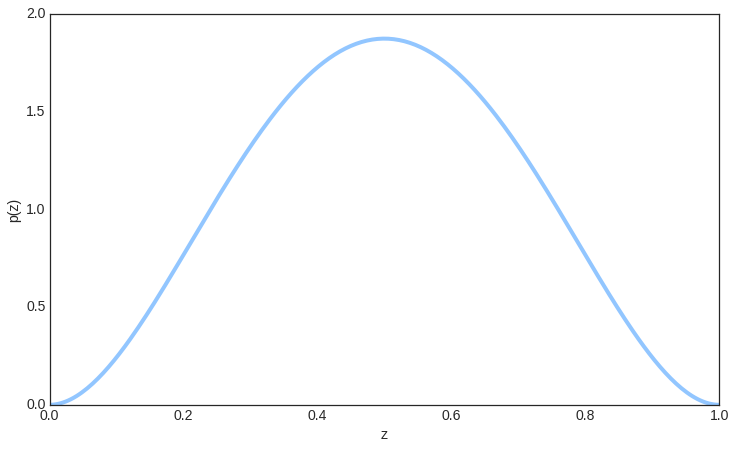

In [2]:
np.random.seed(733)

matplotlib.rcParams.update({'font.size': 14})
plt.style.use(['seaborn-pastel', 'seaborn-white'])

z = np.linspace(0, 1, 250)

# We use Beta[3, 3] as our prior:
prior_a, prior_b = 3, 3

p_z = scs.beta(prior_a, prior_b).pdf(z)

plt.figure(figsize=(12, 7))
plt.plot(z, p_z, linewidth=4.)
plt.xlabel('z')
plt.ylabel('p(z)')
plt.show()

In [3]:
true_z = scs.beta.rvs(prior_a, prior_b)

print 'z =', true_z

x = scs.bernoulli.rvs(true_z, size=30)

print 'x =', x

z = 0.272052135336
x = [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0]


In [4]:
# See https://en.wikipedia.org/wiki/Beta_distribution#Quantities_of_information_.28entropy.29
def KL(a2, b2, a1, b1):
    """Returns the Kullback-Leibler divergence between Beta[a2, b2] and Beta[a1, b1]"""
    return (np.log(scf.beta(a1, b1) / scf.beta(a2, b2)) + (a2 - a1) * scf.psi(a2) + (b2 - b1) * scf.psi(b2) +
            (a1 - a2 + b1 - b2) * scf.psi(a2 + b2))

#print "KL(Beta[3, 3] || Beta[1, 1]) = ", KL(3, 3, 1, 1)
#print "KL(Beta[1, 1] || Beta[3, 3]) = ", KL(1, 1, 3, 3)
#print "KL(Beta[3,.5] || Beta[.5,3]) = ", KL(3, 0.5, 0.5, 3)
#print "KL(Beta[.5,3] || Beta[3,.5]) = ", KL(0.5, 3, 3, 0.5)

# See https://en.wikipedia.org/wiki/Beta_distribution#Geometric_mean
def E_log_p_x_z(x, a2, b2):
    """Returns the expected value of log p(x | z) over z ~ Beta[a2, b2]"""
    return ((x == 1).sum() * (scf.psi(a2) - scf.psi(a2 + b2)) +
            (x == 0).sum() * (scf.psi(b2) - scf.psi(a2 + b2)))

In [5]:
def objective(a2b2):
    return (KL(a2b2[0], a2b2[1], prior_a, prior_b) - E_log_p_x_z(x, a2b2[0], a2b2[1]))

q_trace = [p_z]

res = sco.minimize(objective, [prior_a, prior_b],
                   callback=lambda a2b2: q_trace.append(scs.beta(a2b2[0], a2b2[1]).pdf(z)))

print res.message

Optimization terminated successfully.


In [6]:
"""
Derived from

Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

from matplotlib import animation

def generate_animation(qs):
    p_z_x = scs.beta(prior_a + (x == 1).sum(), prior_b + (x == 0).sum()).pdf(z)

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure(figsize=(12, 7))
    ax = plt.axes(xlim=(0, 1), ylim=(0, 1.1 * p_z_x.max()))
    ax.set_xlabel('z')
    ax.plot(z, p_z, linewidth=4., label='p(z)')
    ax.plot(z, p_z_x, linewidth=4., linestyle='--', dashes=(5, 1), label='p(z | x)')
    approx, = ax.plot([], [], linewidth=2., label='q(z)')
    ax.legend(loc=2 if (x == 1).sum() >= (x == 0).sum() else 1)

    # initialization function: plot the background of each frame
    def init():
        approx.set_data([], [])
        return approx,

    # animation function.  This is called sequentially
    def animate(i):
        if i >= len(qs):
            i = len(qs) - 1
        approx.set_data(z, qs[i])
        return approx,

    interval = 1000 * 15 / len(qs)
    
    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=(len(qs) + (5000 / interval)), interval=interval, blit=True)

    plt.close()
    
    return anim.to_html5_video()

In [7]:
html = generate_animation(q_trace)
HTML(html)

In [8]:
p = scs.beta(prior_a, prior_b)

eps = np.finfo(np.float32).eps

def estimate(a2b2):
    """Returns an estimate of the objective based on Monte Carlo integration"""
    
    if a2b2[0] < 0.0 or a2b2[1] < 0.0:
        return np.inf
    
    q = scs.beta(a2b2[0], a2b2[1])
    
    N = 10000
    
    s_z = q.rvs(size=N)

    s_p_z = p.pdf(s_z) + eps
    s_q_z = q.pdf(s_z) + eps

    return (1. / N) * (np.log(s_q_z / s_p_z) -
                       (x == 1).sum() * np.log(s_z) -
                       (x == 0).sum() * np.log(1 - s_z)).sum()

q_trace = [p_z]

res = sco.minimize(estimate, [prior_a, prior_b], method='Powell',
                   callback=lambda a2b2: q_trace.append(scs.beta(a2b2[0], a2b2[1]).pdf(z)))

print res.message

Optimization terminated successfully.


In [9]:
html = generate_animation(q_trace)
HTML(html)

In [10]:
prior_a, prior_b = float(prior_a), float(prior_b)
n_samples = 10

def log_gaussian_logsigma(x, mu, logsigma):
    return -0.5 * tf.log(2 * np.pi) - logsigma - (x - mu) ** 2 / (2. * tf.exp(2. * logsigma))

def log_beta(x, a, b):
    return (a - 1.) * tf.log(x) + (b - 1.) * tf.log(1. - x) - (tf.lgamma(a) + tf.lgamma(b) - tf.lgamma(a + b))

q_mu = tf.Variable(initial_value=(float(prior_a) / (prior_a + prior_b)), dtype=tf.float32)

q_logsigma = tf.Variable(initial_value=0.5 * np.log(float(prior_a * prior_b) /
                                          ((prior_a + prior_b)**2 * (prior_a + prior_b + 1))),
                       dtype=tf.float32)

tf.set_random_seed(732)
eps = tf.random_normal(shape=[n_samples, 1], mean=0., stddev=1.)

sample_z = tf.clip_by_value(q_mu + tf.exp(q_logsigma) * eps, 0. + 1e-6, 1. - 1e-6)

sample_log_q_z = log_gaussian_logsigma(sample_z, q_mu, q_logsigma)

sample_log_p_z = log_beta(sample_z, prior_a, prior_b)

sample_log_p_x_z = (x == 1).sum() * tf.log(sample_z) + (x == 0).sum() * tf.log(1 - sample_z)

objective = tf.reduce_sum(sample_log_q_z - sample_log_p_z - sample_log_p_x_z) / n_samples

In [11]:
train_op = tf.train.RMSPropOptimizer(learning_rate=0.02).minimize(objective)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    q_trace = [scs.norm(q_mu.eval(), np.exp(q_logsigma.eval())).pdf(z)]
    for _ in range(150):
        _ = sess.run(train_op)
        q_trace.append(scs.norm(q_mu.eval(), np.exp(q_logsigma.eval())).pdf(z))

In [12]:
html = generate_animation(q_trace)
HTML(html)